In [1]:
import pandas
import numpy
import yfinance
import statsmodels.api as sm

import matplotlib.pyplot as plt
import matplotlib

# 1 Introduction

We introduce some elementary risk models to derive the covariance matrix between stocks.

### References

* Grinold, R. C., & Kahn, R. N. (2000). Active portfolio management. (Chapter 3)

### Fetch Data

In [2]:
stocks = ["ACN", "BA", "BAC", "CAT", "HP", "INTC", "KMB", "NVDA", "NFLX", "XRX"]
benchmark = "SPY"

In [3]:
yf = yfinance.Tickers(stocks + [benchmark])
df = yf.download("5y")

[*********************100%%**********************]  11 of 11 completed


In [4]:
df_returns = df["Close"].pct_change().dropna()

### Active and Residual Risk

The active return of a stock against a benchmark is given by,

$$ r_{active} = r_{stock} - r_{benchmark} $$

and the active risk is given by

$$ \sigma_{active} = Std(r_{active}) = Std(r_{stock} - r_{benchmark}) $$

The residual risk is the risk orthogonal to the systematic risk, and is given by

$$ \omega_p = \sqrt{\sigma_P^2 - \beta_P^2 \sigma_B^2} $$

where

$$ \beta_P = \frac{Cov(r_P, r_B)}{Var(r_B)}. $$

For each stock, the beta, total risk and residual risk with respect to the benchmark can be calculated.

In [5]:
def calculate_risk_summary(df_returns, stocks, benchmark):
    out = []
   
    for stock in stocks:
        
        exog = sm.add_constant(df_returns[benchmark], prepend=True)
        endog = df_returns[stock]

        lr = sm.OLS(endog=endog, exog=exog)
        beta = lr.fit().params.loc[benchmark]

        stock_risk = df_returns[stock].std()
        market_risk = df_returns[benchmark].std()

        residual_risk = numpy.sqrt(df_returns[stock].std()**2 - (beta * df_returns[benchmark].std()) ** 2)

        out.append({"Stock": stock, "Beta": beta, "TotalRisk": stock_risk, "ResidualRisk": residual_risk})

    return pandas.DataFrame(out).set_index(keys=["Stock"])

In [6]:
calculate_risk_summary(df_returns, stocks, benchmark)

,Beta,TotalRisk,ResidualRisk
Stock,,,
ACN,1.105547,0.017772,0.010200
BA,1.485289,0.031934,0.025249
BAC,1.241215,0.022438,0.015379
CAT,0.977179,0.020312,0.015720
HP,1.499200,0.038074,0.032560
INTC,1.228634,0.024580,0.018509
KMB,0.452469,0.013660,0.012293
NVDA,1.751760,0.032228,0.022514
NFLX,1.053397,0.028989,0.025457


# 2 Risk Models

### 2.1 Historical Covariance Matrix

The simplest method is to rely on the historical covariances between the stocks. This approach is not robust when there is a large number of stocks $N$ and a limited time-series ($T$) of data, i.e, when $T < N$, as the covariance matrix becomes singular. Further, even if we had a long enough time-series we may wish to exclude data that is "old" and no longer "relevant" due to the changing nature of the market.

In [7]:
def cov_empirical(df_returns, stocks, benchmarks):
    return df_returns[stocks].cov()

In [8]:
cov_empirical(df_returns, stocks, benchmark)

,ACN,BA,BAC,CAT,HP,INTC,KMB,NVDA,NFLX,XRX
ACN,0.000316,0.000259,0.000228,0.000179,0.000251,0.000223,0.000095,0.000324,0.000206,0.000256
BA,0.000259,0.001020,0.000409,0.000320,0.000583,0.000314,0.000071,0.000367,0.000214,0.000472
BAC,0.000228,0.000409,0.000503,0.000303,0.000499,0.000243,0.000079,0.000272,0.000136,0.000376
CAT,0.000179,0.000320,0.000303,0.000413,0.000427,0.000200,0.000056,0.000231,0.000105,0.000324
HP,0.000251,0.000583,0.000499,0.000427,0.001450,0.000323,0.000063,0.000326,0.000151,0.000508
INTC,0.000223,0.000314,0.000243,0.000200,0.000323,0.000604,0.000087,0.000433,0.000261,0.000271
KMB,0.000095,0.000071,0.000079,0.000056,0.000063,0.000087,0.000187,0.000075,0.000056,0.000073
NVDA,0.000324,0.000367,0.000272,0.000231,0.000326,0.000433,0.000075,0.001039,0.000447,0.000310
NFLX,0.000206,0.000214,0.000136,0.000105,0.000151,0.000261,0.000056,0.000447,0.000840,0.000194
XRX,0.000256,0.000472,0.000376,0.000324,0.000508,0.000271,0.000073,0.000310,0.000194,0.000830


### 2.2 The Single Factor Risk Model

For the single factor risk model we examine returns in the following manner

$$ r_i = \beta_i r_M + \epsilon_i $$

where $r_i$ is the return of stock $i$, $\beta_i$ is the beta of stock $i$ to the market's return $r_M$, and $\epsilon_i$ is the residual return.

The model assumes that the residual returns, $\epsilon_i$ are uncorrelated, therefore the covariance between two stocks is given by

$$ Cov(r_i, r_j) = \beta_i \beta_j \sigma_M^2 $$

and the variance of a stock is given by

$$ \sigma_i^2 = \beta_i^2 \sigma_M^2 + \omega_i^2 $$

where $\omega_i$ is the residual risk of stock $n$.

In [9]:
def single_factor_covariance(df_returns, stocks, benchmark):

    df_risk_summary = calculate_risk_summary(df_returns, stocks, benchmark)

    benchmark_var = df_returns[benchmark].var()

    cov_sfr = (
        numpy.outer(df_risk_summary["Beta"], df_risk_summary["Beta"]) * benchmark_var +
        numpy.diag(df_risk_summary["ResidualRisk"] ** 2)
    )

    return pandas.DataFrame(
        data=cov_sfr,
        index=df_risk_summary.index,
        columns=df_risk_summary.index
    )

In [10]:
single_factor_covariance(df_returns, stocks, benchmark)

Stock,ACN,BA,BAC,CAT,HP,INTC,KMB,NVDA,NFLX,XRX
Stock,,,,,,,,,,
ACN,0.000316,0.000285,0.000238,0.000187,0.000287,0.000235,0.000087,0.000336,0.000202,0.000248
BA,0.000285,0.001020,0.000319,0.000252,0.000386,0.000316,0.000116,0.000451,0.000271,0.000333
BAC,0.000238,0.000319,0.000503,0.000210,0.000322,0.000264,0.000097,0.000377,0.000227,0.000278
CAT,0.000187,0.000252,0.000210,0.000413,0.000254,0.000208,0.000077,0.000297,0.000178,0.000219
HP,0.000287,0.000386,0.000322,0.000254,0.001450,0.000319,0.000118,0.000455,0.000274,0.000336
INTC,0.000235,0.000316,0.000264,0.000208,0.000319,0.000604,0.000096,0.000373,0.000224,0.000275
KMB,0.000087,0.000116,0.000097,0.000077,0.000118,0.000096,0.000187,0.000137,0.000083,0.000101
NVDA,0.000336,0.000451,0.000377,0.000297,0.000455,0.000373,0.000137,0.001039,0.000320,0.000393
NFLX,0.000202,0.000271,0.000227,0.000178,0.000274,0.000224,0.000083,0.000320,0.000840,0.000236


### 2.3 The Common Correlation Model

This model makes use of an estimate of each stock's risk $\sigma_i$ and an average correlation between stocks $\rho$. This implies that the covariance between two stocks is given by

$$Cov(r_i, r_j) = \sigma_i \sigma_j \rho $$

In [11]:
def average_pairwise_correlation(df_returns):
    corrs = (numpy.triu(df_returns[stocks].corr()) - numpy.diag(numpy.ones(len(stocks)))).flatten()
    return corrs[corrs != 0].mean()

In [12]:
def common_correlation_covariance(df_returns, stocks, benchmark):
    
    df_risk_summary = calculate_risk_summary(df_returns, stocks, benchmark)
    avg_pairwise_corr = average_pairwise_correlation(df_returns[stocks])
    stock_risks = df_risk_summary["TotalRisk"]

    cov = numpy.outer(stock_risks, stock_risks) * avg_pairwise_corr

    cov[numpy.diag_indices_from(cov)] = numpy.diag(cov) / avg_pairwise_corr

    return pandas.DataFrame(
        data=cov,
        index=df_risk_summary.index,
        columns=df_risk_summary.index
    )

In [13]:
common_correlation_covariance(df_returns, stocks, benchmark)

Stock,ACN,BA,BAC,CAT,HP,INTC,KMB,NVDA,NFLX,XRX
Stock,,,,,,,,,,
ACN,0.000316,0.000218,0.000153,0.000138,0.000259,0.000167,0.000093,0.000220,0.000198,0.000196
BA,0.000218,0.001020,0.000275,0.000249,0.000466,0.000301,0.000167,0.000395,0.000355,0.000353
BAC,0.000153,0.000275,0.000503,0.000175,0.000328,0.000211,0.000118,0.000277,0.000249,0.000248
CAT,0.000138,0.000249,0.000175,0.000413,0.000296,0.000191,0.000106,0.000251,0.000226,0.000224
HP,0.000259,0.000466,0.000328,0.000296,0.001450,0.000359,0.000199,0.000470,0.000423,0.000421
INTC,0.000167,0.000301,0.000211,0.000191,0.000359,0.000604,0.000129,0.000304,0.000273,0.000271
KMB,0.000093,0.000167,0.000118,0.000106,0.000199,0.000129,0.000187,0.000169,0.000152,0.000151
NVDA,0.000220,0.000395,0.000277,0.000251,0.000470,0.000304,0.000169,0.001039,0.000358,0.000356
NFLX,0.000198,0.000355,0.000249,0.000226,0.000423,0.000273,0.000152,0.000358,0.000840,0.000320


## 2.4 Out of Sample Performance

We compare the out of sample performance of the different risk models by comparing the estimated covaraince matrix on day $T$ with the realised covariance matrix over a subsequent period from $T + 1$ to $T + N$.

In [14]:
dates = df_returns.index.tolist()
train_window = 126
test_window = 21

In [15]:
def norm(cov_train, cov_test):
    """Sum of squares"""
    return numpy.power(cov_test - cov_train, 2).sum().sum()

In [16]:
models = {
    "Empirical": cov_empirical,
    "SingleFactor": single_factor_covariance,
    "CommonCorrelation": common_correlation_covariance,
}

In [17]:
out = []

for ix in range(train_window, len(dates) - test_window):

    df_returns_train = df_returns.iloc[ix-train_window:ix]
    df_returns_test = df_returns.iloc[ix:ix+test_window]

    cov_test = cov_empirical(df_returns_test, stocks, benchmark)

    for name, model in models.items():
        cov_tr = model(df_returns_train, stocks, benchmark)
        err = norm(cov_tr, cov_test)

        out.append({
            "Date": dates[ix],
            "Model": name,
            "Error": err
        })

df_errors = (
    pandas.DataFrame(out)
    .set_index(keys=["Date", "Model"])
    .unstack(1)
    ["Error"]
)

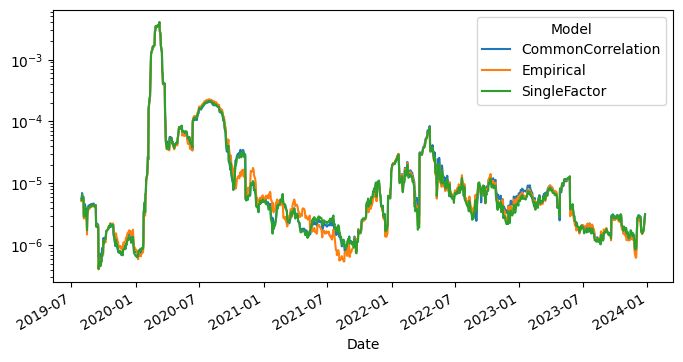

In [18]:
f, ax = plt.subplots(1, 1, figsize=(8, 4))

df_errors.plot(ax=ax)

ax.set_yscale("log")

The elementary risk models are comparable to the empirical covariance matrix calculation with respect to estimating the out of sample covariance matrix.